1. day period -- close ma10 upper cross ma20
2. day period -- volume : volume upper cross ma5
3. day period -- volume : ma5 upper cross ma40
4. day period -- volume : ma40 upper cross ma135

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import QUANTAXIS as QA
import talib as ta
import datetime #, time

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

In [10]:
stock_list = QA.QA_fetch_stock_list_adv()

In [5]:
# start = QA.QA_util_get_last_day(end,n=140)
start = '2018-01-01'
end = '2019-02-01'

In [19]:
stock_list.head()

,code,decimal_point,name,pre_close,sec,sse,volunit
code,,,,,,,
000001,000001,2,平安银行,824.01250,stock_cn,sz,100
000002,000002,2,万 科Ａ,27.68000,stock_cn,sz,100
000004,000004,2,国农科技,1816.02750,stock_cn,sz,100
000005,000005,2,世纪星源,3970.00125,stock_cn,sz,100
000006,000006,2,深振业Ａ,5.28000,stock_cn,sz,100


In [9]:
# stock_list = stock_list.index.tolist()

In [11]:
code_list_non_st = stock_list[stock_list.name.apply(lambda x : True if ((x[:2].lower() != 'st') | \
                      (x[:3].lower() != '*st')) else False)].index.tolist()

In [13]:
# code_list_non_st[:10]

In [14]:
data = QA.QA_fetch_stock_day_adv(code_list_non_st, start, end).to_qfq()

In [15]:
def buy_triple(dataframe):
    CLOSE = dataframe.close
    VOLUME = dataframe.volume
    
    close_ma10 = QA.MA(CLOSE, 10)
    close_ma20 = QA.MA(CLOSE, 20)
    
    volume_ma5 = QA.MA(VOLUME, 5)
    volume_ma40 = QA.MA(VOLUME, 40)
    volume_ma135 = QA.MA(VOLUME, 135)
    
    var = QA.CROSS(close_ma10, close_ma20) * QA.CROSS(VOLUME, volume_ma5) * \
    QA.CROSS(volume_ma5, volume_ma40) * QA.CROSS(volume_ma40, volume_ma135)
    
    return pd.DataFrame({'buyTriple':var})

In [16]:
ind = data.add_func(buy_triple)

In [17]:
inc = QA.QA_DataStruct_Indicators(ind)

In [18]:
ind[ind.buyTriple == 1]

,,buyTriple
date,code,
2018-09-26,300274,1
2018-11-07,600267,1
2019-01-08,300337,1
2019-01-15,600197,1
2019-01-16,000897,1
2019-01-25,603579,1


In [31]:
code_signal = ind[ind.buyTriple == 1].index.get_level_values(1).tolist()

In [27]:
stock_list.head()

,code,decimal_point,name,pre_close,sec,sse,volunit
code,,,,,,,
000001,000001,2,平安银行,824.01250,stock_cn,sz,100
000002,000002,2,万 科Ａ,27.68000,stock_cn,sz,100
000004,000004,2,国农科技,1816.02750,stock_cn,sz,100
000005,000005,2,世纪星源,3970.00125,stock_cn,sz,100
000006,000006,2,深振业Ａ,5.28000,stock_cn,sz,100


In [34]:
stock_list[stock_list.code.apply(lambda x : x in code_signal)]

,code,decimal_point,name,pre_close,sec,sse,volunit
code,,,,,,,
000897,000897,2,津滨发展,1090.014375,stock_cn,sz,100
300274,300274,2,阳光电源,968.020000,stock_cn,sz,100
300337,300337,2,银邦股份,5250.008750,stock_cn,sz,100
600197,600197,2,伊力特,1688.037500,stock_cn,sh,100
600267,600267,2,海正药业,40.045000,stock_cn,sh,100
603579,603579,2,荣泰健康,27.910000,stock_cn,sh,100


In [39]:
data.select_code(code_signal).data.head()

open       high        low      close         volume  \
date       code                                                                
2018-01-02 000897   3.400000   3.470000   3.390000   3.420000   81608.000000   
           300274  18.834819  19.082907  18.586731  19.043213  166911.733903   
           300337   8.169526   8.219462   8.069654   8.189501   27621.366667   
           600197  23.154767  23.233894  22.600872  22.996511   43255.604938   
           600267  15.112684  15.331998  14.923277  15.112684   59516.757671   

                        amount  preclose       adj  
date       code                                     
2018-01-02 000897   28001136.0       NaN  1.000000  
           300274  314623232.0       NaN  0.992351  
           300337   22449026.0       NaN  0.998720  
           600197   98975456.0       NaN  0.989097  
           600267   89711112.0       NaN  0.996879

In [46]:
data_filtered = data.select_code(code_signal)

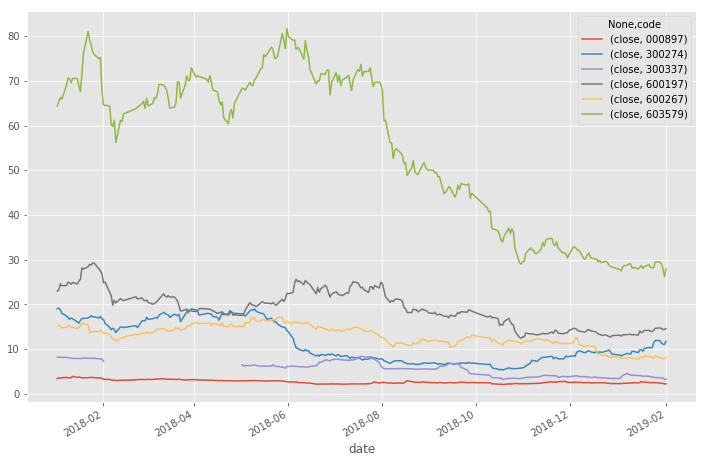

In [47]:
data_filtered.data.pivot_table(values=['close'], index=['date'], columns=['code']).plot();

In [65]:
def calc_cum_pct(dataframe):
    CLOSE = dataframe.close
    pct = CLOSE.pct_change()
    cum_pct = (1 + pct).cumprod()
    return pd.DataFrame({'cum_return':cum_pct})

In [66]:
ind_cum_pct = data_filtered.add_func(calc_cum_pct)

In [67]:
inc_cum_pct = QA.QA_DataStruct_Indicators(ind_cum_pct)

In [68]:
inc_cum_pct.data.tail()

cum_return
date       code              
2019-02-01 300274    0.618068
           300337    0.401734
           600197    0.634879
           600267    0.540605
           603579    0.433700

In [74]:
inc_cum_pct.get_timerange('2019-01','2019-02').index.names

FrozenList(['date', 'code'])

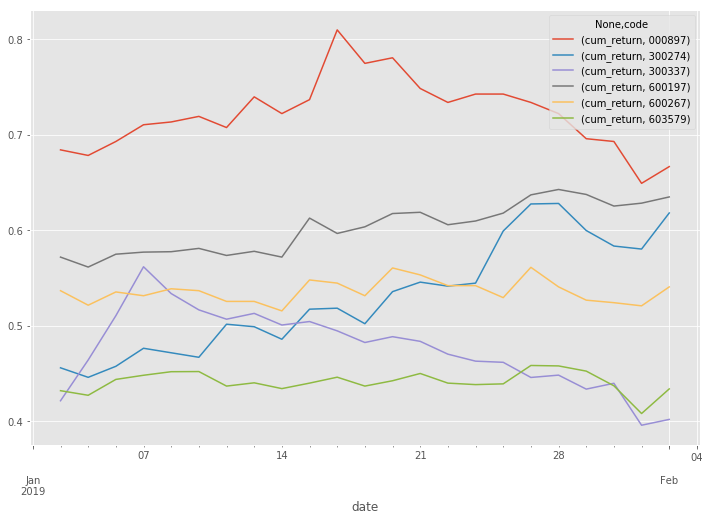

In [76]:
inc_cum_pct.get_timerange('2019-01','2019-02').pivot_table(
                            values=['cum_return'],
                            index=['date'],
                            columns=['code']).plot();

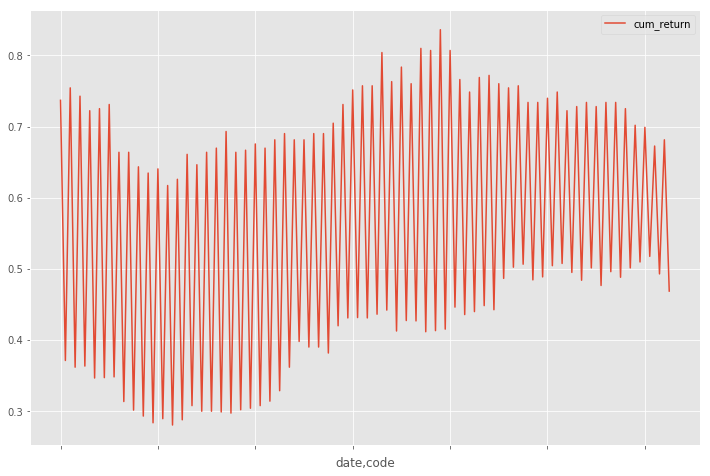

In [77]:
inc_cum_pct.get_timerange('2018-09-26', '2019', '300274').plot();

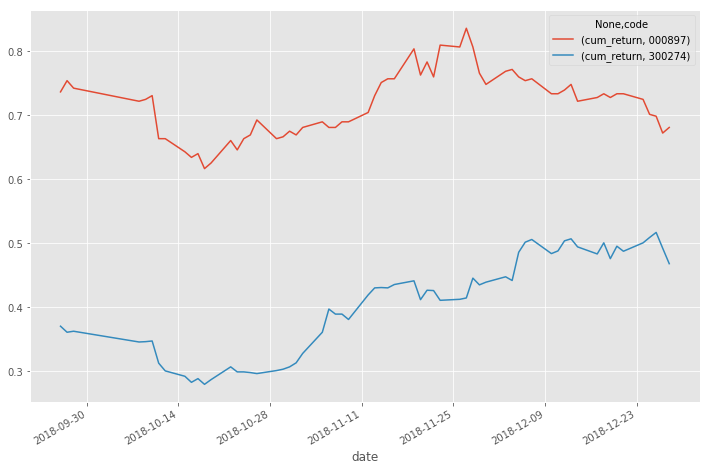

In [81]:
inc_cum_pct.get_timerange('2018-09-26', '2019', code='300274').pivot_table(
                            values=['cum_return'],
                            index=['date'],
                            columns=['code']).plot();